<h2 align="center">Линейная регрессия</h2>


В общем виде уравнение линейной регрессии выглядит следующим образом:

**Простая линейная регрессия**: <h5 align=center>$$Y = \beta_0 + \beta_1 X + \epsilon$$</h5>

**Множественная линейная регрессия**: <h5 align=center>$$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 +...+ \beta_p X_p + \epsilon$$ </h5>

Соответственно наша задача определить коэффициенты, наилучшим образом описывающие наши данные. 

Для начала импортируем данные и проведем предварительный анализ. Данные описывают затраты на рекламу по телевизору, на радио и в газетах и количество продаж по двумста магазинам.

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import skew
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12, 8)


### **Импорт данных**


In [2]:
dataset = pd.read_csv('Advertising.csv')
dataset.head()

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [3]:
print(dataset.columns)
print(dataset.shape)

Index(['Unnamed: 0', 'TV', 'radio', 'newspaper', 'sales'], dtype='object')
(200, 5)


Как видно, колонка с индексами не имеет отношения к данным, уберем её.

In [4]:
dataset.drop(['Unnamed: 0'], axis = 1, inplace = True)
print(dataset.shape)

(200, 4)


*Важно помнить о сохранности исходных данных* (inplace = True). <br>
### **Проверка данных на NaN**
Но, прежде чем приступить к анализу входных данных, нужно их проверить на отсутствующие значения.

In [5]:
dataset.isna().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

Все значения на месте. Но что делать, если некоторые отсутствуют? Мы можем выбрать из двух вариантов: исключать недостающие значения или использовать значения последовательности для генерации недостающих.
Рассмотрим оба варианта.

**Удаление недостающих значений.**

pandas.DataFrame.dropna()

Здесь мы можем пойти несколькими путями.<br>
Удалять столбец, то есть исключать предиктор из исследования целиком:


In [6]:
dataset.dropna(axis=1, inplace=True)

Удалять строку. Тут важно помнить, что мы удаляем значения с соответствующим индексом из *всех* столбцов, то есть вносим изменения в весь набор данных:

In [7]:
dataset.dropna(axis=0, inplace=True)

Но мы можем явно указать колонку для обработки:

In [8]:
dataset.dropna(subset=['TV'],axis=0,inplace=True)

И в заключение, мы можем удалять колонку при условии некоторого процента отсутствующих значений:

In [9]:
dataset.dropna(thresh=0.8*len(dataset),axis=1,inplace=True)
print(dataset.shape)

(200, 4)


Как мы видим ничего удалено небыло.

**Генерация недостающих значений.** <br>
Тут мы можем подставлять значение некоторой функции от остальной последовательности (среднее значение, например) или просто заданное значение. Это для числовых данных.<br>Для категориальных мы можем подставить самое часто встречающееся, например.

In [10]:
numeric = dataset.select_dtypes(include=np.number)
numeric_columns = numeric.columns
dataset[numeric_columns] = dataset[numeric_columns].fillna(dataset.mean())
print(numeric_columns)

Index(['TV', 'radio', 'newspaper', 'sales'], dtype='object')


### **Удаление дубликатов.**

Название раздела отражает его суть. Зачем нам обрабатывать одни и те-же данные?

In [11]:
print(dataset.duplicated().sum())
dataset.drop_duplicates(inplace=True)

0


### **Визуальный анализ входных данных.**

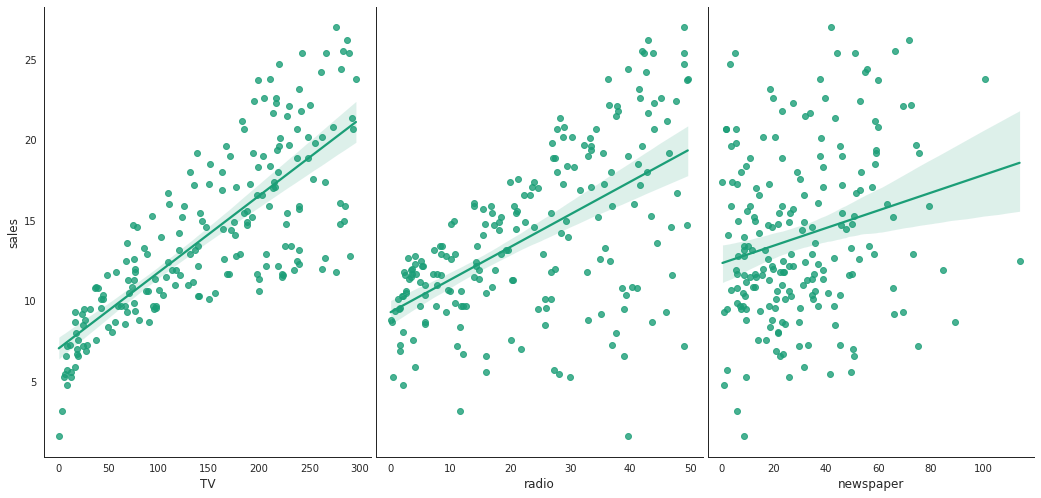

In [12]:
sns.set_style(style='white')
sns.set_palette(sns.color_palette("Dark2"))
sns.pairplot(dataset, x_vars=['TV', 'radio', 'newspaper'], y_vars='sales', height=7, aspect=0.7, kind='reg')

И тут начинается интересное. А что, собственно, мы тут видим? <br>
А види мы тут, как минимум, что доверительный интервал для newspaper слишком большой. Что это значит? То, что newspaper имеет малую корреляцию с выходом и мало на него влияет. <br>
Но было бы очень неплохо увидеть это в цифрах.

<AxesSubplot:>

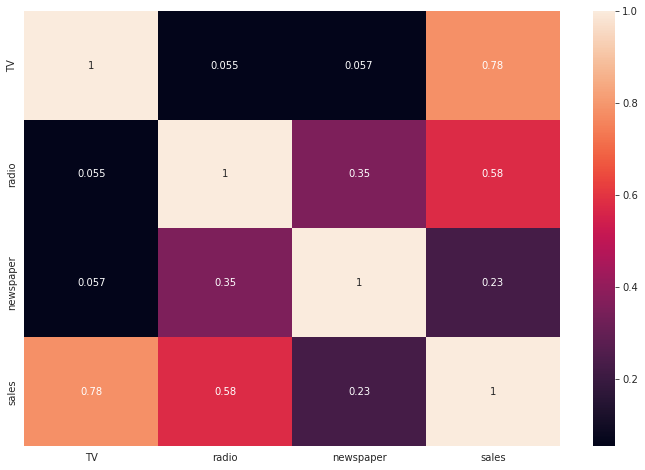

In [13]:
sns.heatmap(dataset.corr(), annot=True)

Моё понимание происходящего. <br>

1. Корреляция (связь двух величин, то есть влияние одной на другую) с выходом самая высокая у TV. Это самый значимый предиктор.
2. В мультиколлениарность мы тут не влетим, наши предикторы описывают выход, а не друг друга.
3. Нужно подумать о выкинуть newspaper.


### **Нормализация входных данных.**

Суть нормализации в как-бы обезразмеривании данных. Если в нашей модели присутствовали, например, расстояние до звезды и её видимый размер. То количественная разница значений была-бы огромна. Что могло бы привести к неправильному обучению. Нормализация позволяет нам сбалансировать предикторы, перемасштабировать их, не теряя семантики. <br>
Есть много вариантов, но мне больше всего понравилась нормализация средним или Z-оценка. Поскольку она хорошо (на мой взгляд) работает с выбросами.

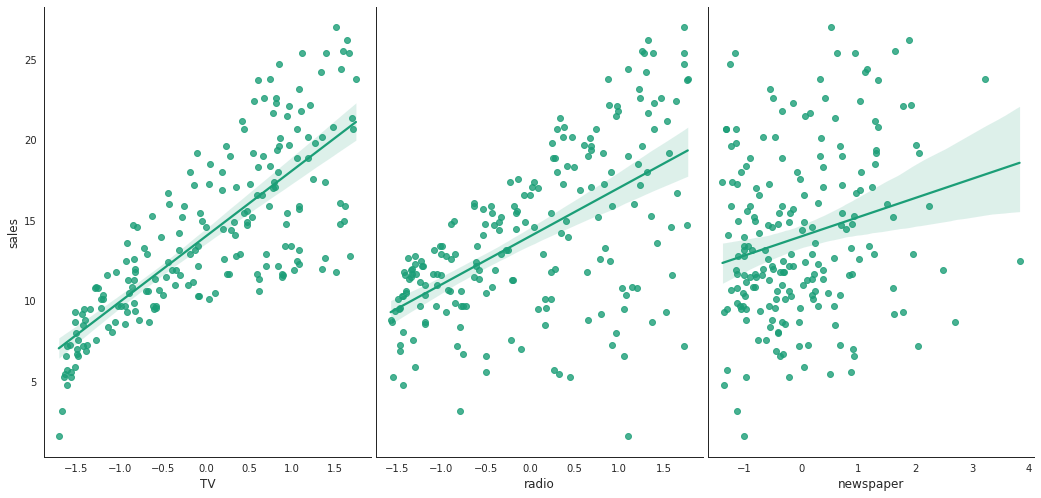

In [14]:
for key in dataset:
    if key != 'sales':
        dataset[key] = (dataset[key]-dataset[key].mean())/dataset[key].std() 
sns.pairplot(dataset, x_vars=['TV', 'radio', 'newspaper'], y_vars='sales', height=7, aspect=0.7, kind='reg')

<AxesSubplot:>

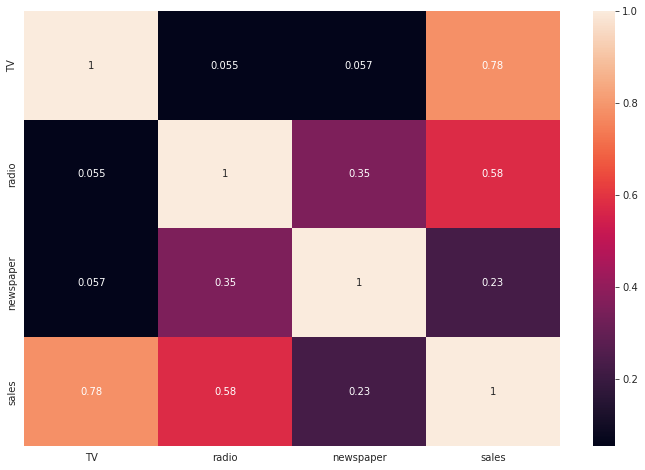

In [15]:
sns.heatmap(dataset.corr(), annot=True)

Из графиков водно, что нормализация никак не повлияла на семантику, но при это мы имеем гораздо более близкие диапазоны предикторов.

In [16]:
dataset.head()

,TV,radio,newspaper,sales
0,0.967425,0.979066,1.774493,22.1
1,-1.194379,1.080097,0.667903,10.4
2,-1.512360,1.524637,1.779084,9.3
3,0.051919,1.214806,1.283185,18.5
4,0.393196,-0.839507,1.278593,12.9


### **Отбор признаков**

$R^2$ метрика. Или коэффициент детерминации. Очень важная штука. Показывает количественно, насколько точно наша модель описывает предсказываемую переменную.

Итак, исследуем влияние каждого из предикторов на выходную переменную.

In [32]:
X = dataset[['TV', 'radio', 'newspaper']]
y = dataset.sales

model = LinearRegression().fit(X[['TV', 'radio', 'newspaper']], y)
prediction = model.predict(X[['TV', 'radio', 'newspaper']])

print("For model with TV, radio, newspaper predictors R2 score is: {:.5f}\nCoefficients are: {}".format(r2_score(y, prediction), model.coef_))

model = LinearRegression().fit(X[['TV', 'radio']], y)
prediction = model.predict(X[['TV', 'radio']])

print("\nFor model with TV, radio predictors R2 score is: {:.5f}\nCoefficients are: {}".format(r2_score(y, prediction), model.coef_))

model = LinearRegression().fit(X[['TV', 'newspaper']], y)
prediction = model.predict(X[['TV', 'newspaper']])

print("\nFor model with TV, newspaper predictors R2 score is: {:.5f}\nCoefficients are: {}".format(r2_score(y, prediction), model.coef_))

model = LinearRegression().fit(X[['radio', 'newspaper']], y)
prediction = model.predict(X[['radio', 'newspaper']])

print("\nFor model with radio, newspaper predictors R2 score is: {:.5f}\nCoefficients are: {}".format(r2_score(y, prediction), model.coef_))

For model with TV, radio, newspaper predictors R2 score is: 0.89721
Coefficients are: [ 3.92908869  2.79906919 -0.02259517]

For model with TV, radio predictors R2 score is: 0.89719
Coefficients are: [3.92824471 2.79111441]

For model with TV, newspaper predictors R2 score is: 0.64584
Coefficients are: [4.0266679  0.96303807]

For model with radio, newspaper predictors R2 score is: 0.33271
Coefficients are: [2.9551771  0.14470096]


Цифры жестоки и беспощадны - прощай, newspaper!